In [1]:
%matplotlib inline
import numpy as np
import imageio
import scipy.io
import scipy.misc
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import glob
import os
import re
from os import listdir
# from os.path import isfile, join
import matplotlib.pyplot as plt 
from matplotlib import style 
from math import sqrt
from PIL import Image
from sklearn.metrics import confusion_matrix
# import scikitplot.metrices as skplt # plot confusion matrics skplt.plot_confusion_matrix(y_test, y_predict)
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from skimage.color import rgb2gray


mypath = 'C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/images_Landmass.mat'


Shape of data array:  (2000, 99, 99)


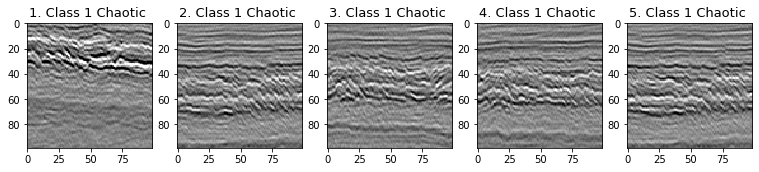

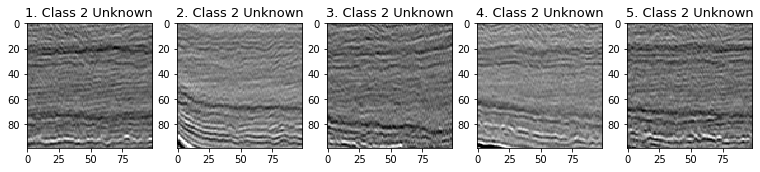

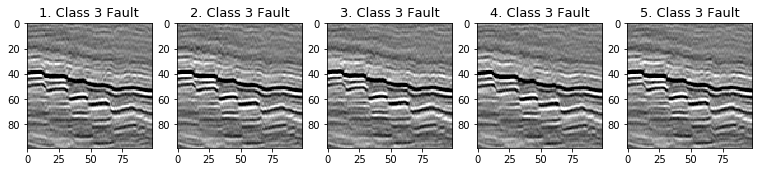

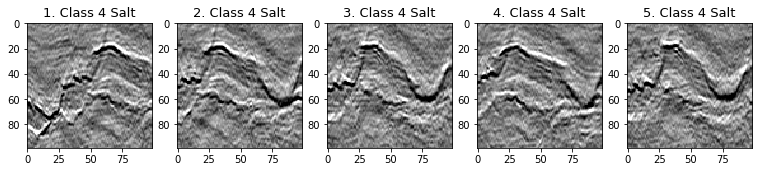

There are 2000 texture images. Each image has dimension:  (99, 99)


In [2]:
# Draw raw
list_data = scipy.io.loadmat(mypath)['images']
# print(len(list_data))
array_data = np.array(list_data)
print('Shape of data array: ', array_data.shape)

fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 1 Chaotic " , fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n+500], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 2 Unknown", fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n+1000], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 3 Fault", fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(13, 13))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n+1500], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 4 Salt", fontsize=13)
plt.show()
width = array_data[0].shape[0]
length = array_data[0].shape[1]
print('There are', len(array_data), 'texture images. Each image has dimension: ', array_data[0].shape)

In [3]:
# from PIL import Image
# #Rescale to 0-255 and convert to uint8
# nn = 1888
# rescaled = (255.0 / array_data[nn].max() * (array_data[nn] - array_data[nn].min())).astype(np.uint8)

# im = Image.fromarray(rescaled)
# im.save('LANDMASS_Salt.png')

In [4]:
NumOfClasses = 4
# numImages is total num of images
numImages = array_data.shape[0]
print(numImages)
# Same number of images per class
numImagesPerClass = int(numImages/NumOfClasses) 
print(type(numImagesPerClass))
X = np.reshape(array_data,(numImages,array_data.shape[1]*array_data.shape[2])).T
print('Data matrix X shape: ', X.shape)
# Check if there is negative element in the matrix. The dataset should be normalised to [0, 1]
if (X < 0).any():
    print('Matrix elements are not all positive!')

2000
<class 'int'>
Data matrix X shape:  (9801, 2000)


In [5]:
# split features based on classes
X_ch = X[:,:numImagesPerClass] #Chaotic
X_ot = X[:, numImagesPerClass:numImagesPerClass*2] # Unknown
X_fa = X[:, numImagesPerClass*2:numImagesPerClass*3] # Fault
X_sa = X[:, numImagesPerClass*3:numImagesPerClass*4] #Salt Dome

N_p = len(X_ch)
set_sparsity = 0.6
L1toL2 = sqrt(N_p) - sqrt(N_p-1)*set_sparsity # L1L2ratio for sigle class


In [6]:
k_clusters = 250
# Perform kmeans on each dataset features
kmeans_ch = KMeans(n_clusters=k_clusters, max_iter=1000).fit(X_ch.T)
kmeans_ot = KMeans(n_clusters=k_clusters, max_iter=1000).fit(X_ot.T)
kmeans_fa = KMeans(n_clusters=k_clusters, max_iter=1000).fit(X_fa.T)
kmeans_sa = KMeans(n_clusters=k_clusters, max_iter=1000).fit(X_sa.T)

In [7]:
centr_ch = kmeans_ch.cluster_centers_.T
centr_ot = kmeans_ot.cluster_centers_.T
centr_fa = kmeans_fa.cluster_centers_.T
centr_sa = kmeans_sa.cluster_centers_.T
# initialize W and H
# W_init_list = [centr_ch.T, centr_ot.T, centr_fa.T, centr_sa.T]
# W=M*r, H = r*N, V = W.H, W is basis matrix, each column is a basis vector
np.random.seed(20)
H_init = np.random.uniform(0.0, 1.0, size = (NumOfClasses*k_clusters, numImages))
# H_init = np.random.randn(NumOfClasses*k_clusters, numImages)
W_init = np.hstack((centr_ch, centr_ot, centr_fa, centr_sa))
# Make sure all the centroids are nonnegative
W_init[W_init<0.001] = 0
# print('H_init : \n',H_init)
pop = np.where(centr_ch==0)
print(pop[0].shape)
print(W_init)

(4761,)
[[0.458125   0.48841667 0.5194375  ... 0.5970625  0.518      0.4944375 ]
 [0.41814583 0.50033333 0.4554375  ... 0.4478125  0.47715625 0.4716875 ]
 [0.4035625  0.48454167 0.4765625  ... 0.3235625  0.473875   0.525625  ]
 ...
 [0.5011875  0.452875   0.545375   ... 0.4858125  0.4759375  0.4696875 ]
 [0.4874375  0.44683333 0.575375   ... 0.4691875  0.44190625 0.4310625 ]
 [0.52835417 0.43879167 0.5661875  ... 0.423      0.4405625  0.5219375 ]]


In [8]:
# Used kmeans centroid as W and H initialisation. Use nmf package for updating W and H.

modelTest1 = NMF(n_components=1000, init='custom', solver='mu', beta_loss='frobenius', tol=0.0001, max_iter=600, random_state=None, alpha=0.1, l1_ratio=L1toL2)
W_all = modelTest1.fit_transform(X, W = W_init, H = H_init)
H_all = modelTest1.components_

Numerical solver to use: ‘cd’ is a Coordinate Descent solver
‘mu’ is a Multiplicative Update solver.

In [9]:
'''Nonnegative Double Singular Value Decomposition (NNDSVD)
            initialization (better for sparseness)
            NNDSVD with zeros filled with small random values
            (generally faster, less accurate alternative to NNDSVDa
            for when sparsity is not desired)'''
# Chaotic
NMFmodel= NMF(n_components=250,init='nndsvdar', solver='mu', beta_loss='frobenius', tol=0.0001, max_iter=500, random_state=None, alpha=0.0, l1_ratio=L1toL2)
W_ch = NMFmodel.fit_transform(X_ch)
H_ch = NMFmodel.components_

C:\Users\Tsaip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [10]:
# Unknown
W_o = NMFmodel.fit_transform(X_ot)
H_o = NMFmodel.components_

C:\Users\Tsaip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [11]:
# Salt Dome
W_s = NMFmodel.fit_transform(X_sa)
H_s = NMFmodel.components_

C:\Users\Tsaip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [12]:
# Fault
W_f = NMFmodel.fit_transform(X_fa)
H_f = NMFmodel.components_

C:\Users\Tsaip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


### Stacked process option 1: stack single class nmf result together

In [13]:
k = 250
H_vstack = np.concatenate((H_ch, H_o, H_f, H_s), axis = 0)
H_conc = np.zeros((k*NumOfClasses, numImages))
W_conc = np.concatenate((W_ch, W_o, W_f, W_s), axis = 1)
H_conc[:k, :numImagesPerClass] = H_ch
H_conc[k:k*2, numImagesPerClass:numImagesPerClass*2] = H_o
H_conc[k*2:k*3, numImagesPerClass*2:numImagesPerClass*3] = H_f
H_conc[k*3:k*4, numImagesPerClass*3:numImagesPerClass*4] = H_s

### Stacked process option 2: stack single class nmf H on whole dataset nmf H

In [14]:
# combine single class of H result onto all class result H
# Concatenate W and H to to facilitate stacked calculation
k = 250
H_vstack = np.concatenate((H_ch, H_o, H_f, H_s), axis = 0)
H_concat = H_all
# W_conc = np.concatenate((W_ch, W_o, W_f, W_s), axis = 1)
H_concat[:k, :numImagesPerClass] = H_ch
H_concat[k:k*2, numImagesPerClass:numImagesPerClass*2] = H_o
H_concat[k*2:k*3, numImagesPerClass*2:numImagesPerClass*3] = H_f
H_concat[k*3:k*4, numImagesPerClass*3:numImagesPerClass*4] = H_s

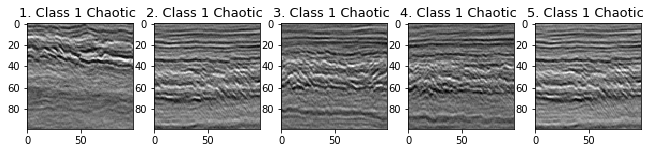

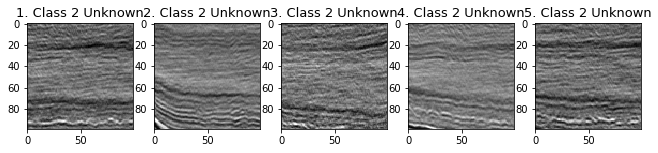

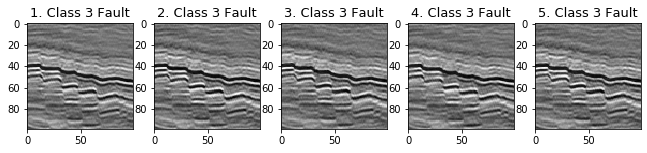

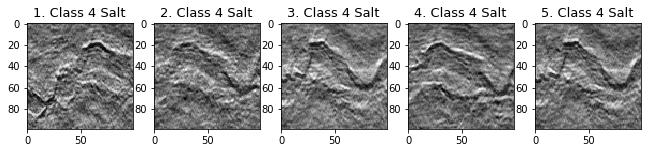

In [15]:
WH_product = np.dot(W_conc, H_concat)
# WH_product = np.dot(W_all, H_all)
img_nmf_all = np.reshape(WH_product.T, (numImages,99,99))

fig, axarr = plt.subplots(1, 5, figsize=(11, 11))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(img_nmf_all[n], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 1 Chaotic " , fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(11, 11))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(img_nmf_all[n+500], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 2 Unknown", fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(11, 11))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(img_nmf_all[n+1000], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 3 Fault", fontsize=13)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(11, 11))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(img_nmf_all[n+1500], cmap='gray')
    ax.set_title("%i. " % (n+1) + "Class 4 Salt", fontsize=13)
plt.show()
# clear memory
del WH_product

### Plot distribution of two W to see feature magnitude distribution

In [16]:
def plotHistogram_W(W1, name1, W2, name2):
    f, axs = plt.subplots(1,2, figsize=(15,3))
    W_ = np.array([W1, W2])
    name_ = np.array([name1, name2])
    im = np.arange(2)
    # Plot distribution of two W
    for n, W, name in zip(im, W_, name_):
        W_flat = np.reshape(W, (W.shape[0]*W.shape[1],))
        w1 = W_flat[0:W.shape[0]*k]
        w2 = W_flat[W.shape[0]*k:W.shape[0]*k*2]
        w3 = W_flat[W.shape[0]*k*2:W.shape[0]*k*3]
        w4 = W_flat[W.shape[0]*k*3:W.shape[0]*k*4]

        # You can normalize it by setting 
        # density=True and stacked=True. By doing this the total area under each distribution becomes 1.
        #  , density=True, stacked=True
        kwargs = dict(alpha=0.45)

        axs[n].hist(w1, **kwargs, color='g', label='chaotic' )
        axs[n].hist(w2, **kwargs, color='b', label='unknown')
        axs[n].hist(w3, **kwargs, color='r', label='fault')
        axs[n].hist(w4, **kwargs, color='k', label='salt')
        axs[n].set_title('Frequency Histogram of '+name)
        axs[n].set_xlabel('Seismic Feature Magnitude',fontsize=14)
        axs[n].set_ylabel('Frequency',fontsize=14)
        axs[n].legend(prop={'size': 14})
    plt.show()
    print('The above histogram shows distibution of features in two different W')
    return 

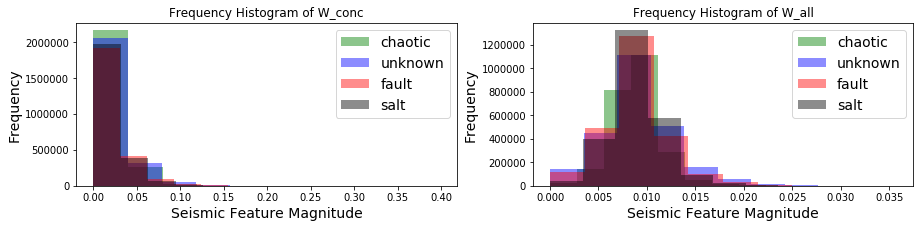

The above histogram shows distibution of features in two different W


In [17]:
plotHistogram_W(W_conc, 'W_conc', W_all, 'W_all')

### What do the histograms tell us?
- For single class NMF, most of the feature magnitude falls between 0 and 0.1. Data skewed to the right. Only few larger values bring the mean upwards but don’t really affect the median. 
- Single class NMF results in more compact and significant feature pattern. Features are very compact so it is hard to distinguish different seismic structures.
- Stacked classes NMF resultsin wider distribution regarding feature magnitude. Each class of features has more distinguished mean and median magnitude which makes NMF learn features of different class more easily.

In [18]:
# # just for testing
# print('W_conc shape: ',W_conc.shape)
# print('W_all shape: ',W_all.shape)
# W_flat = np.reshape(W_all, (W_all.shape[0]*W_all.shape[1],))
# print('Each W has ',W_flat.shape[0],'elements')
# w1 = W_flat[0:W_all.shape[0]*k]
# print('w1 is the first class. w1 has shape: ', w1.shape)
# print('w1 looks like:',w1)

### Plot difference in single class and all classes $W$ and $H$
- Single class nmf result has 250 feature components per image. All dataset nmf result has 1000 feature components per image.
- H_all and H_conc indicate the features weights used to construct nth image.
- We want to show sparsity of W. We expect a good W will be more sparsed.

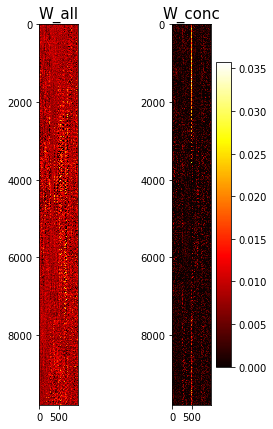

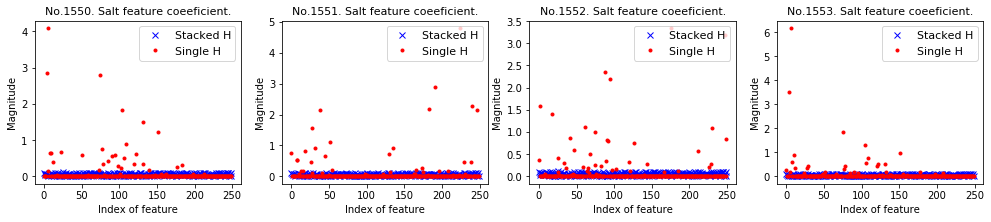

In [19]:
# Plot some H for insight
# To check the difference between stacked W NMF output and single W NMF output
n = 1550 # nth image
x = np.arange(k)

f, axs = plt.subplots(1,2, figsize=(4,7))
im0 = axs[0].imshow(W_all, cmap='hot', interpolation='nearest')
axs[0].figure.colorbar(im0)
axs[0].set_title('W_all',fontsize=15)
im1 = axs[1].imshow(W_conc, cmap='hot', interpolation='nearest')
axs[1].set_title('W_conc',fontsize=15)
f.savefig('W.jpg')
# Plot salt feature coefficient only for a quick observation
numPlot = 4
f, axs = plt.subplots(1,numPlot, figsize=(17,3))
for ii in range(numPlot):
    y1 = H_concat[0:k, n-1]
    y2 = H_s[:, n-1500+ii-1]
    lg1, = axs[ii].plot(x, y1, 'bx', label='Stacked H')
    lg2, = axs[ii].plot(x, y2,'r.', label = 'Single H')
    axs[ii].set_xlabel("Index of feature")
    axs[ii].set_ylabel("Magnitude")
    axs[ii].set_title("No.%i. Salt feature coeeficient."%(n+ii),fontsize=11)
    axs[ii].legend(handles=[lg1, lg2], loc = 'upper right',fontsize=11)
f.savefig('H.jpg')

1. Some analysis for $W$:
    - Every element in matrix W represents single seismic structure. We can see that single class nmf results in higher magnitude contrast. This means the seismic features are more distinguished in single class nmf result.
2. Some analysis for $H$:
    - Graphs for salt feature coefficients indicate the weight of each geophysical structure.single H in red has more feature weights that lies outside the mean line.

### Create a normalised data matrix 
- create classification matrix Qr. Use Qr to divide every column of H into 4 classes.
- multiply single row of W by single column of H. 
- There are 9801 rows of W. Each elements represents a seismic structure. 
- There are 2000 columns of H. Each column represents features used to represent nth image.

In [20]:
def normalizeColumns(matrix):
# normalizes the input matrix to have the L1 norm of each column = 1
    output = np.zeros((matrix.shape))
    for i in range(matrix.shape[1]):
        output[:,i] = np.divide(matrix[:,i], sum(abs(matrix[:,i])))
    return output

In [34]:
Qr = np.kron(np.eye(NumOfClasses, NumOfClasses), np.ones((250,1)))
Qr = normalizeColumns(Qr)
Y = np.zeros((numImages, width*length, NumOfClasses))
N_class = np.ones((1,NumOfClasses))

for img in range(0, numImages):
    Hi = np.reshape(H_concat[:,img],(len(H_concat[:,img]),1))
    # map the coefficients of each image into the seismic structures that make up that image
    # Each Y shows the likelihood of each seismic structure for each pixel in the image.
    H_class = np.dot(Hi,N_class)
    WH_i = np.dot(W_conc, np.multiply(Qr, H_class))
#     print('len(WH_product)',len(WH_product))
    Y[img,:, :] = WH_i

### Filter just one image first

In [22]:
# gaussian_filtering = True
# sigma = 0.4
# n = 1501
# Y_n = Y[n, :, :]

# if gaussian_filtering:
#     for label in range(NumOfClasses):
#         temp = np.reshape(Y_n[: ,label].T,(width,length))
#         temp = gaussian_filter(temp,sigma)
#         Y_n[:,label] = np.reshape(temp,(width*length,))


### ===================== The following is to process stacked classes =========================
### Filter all the images at once
- `sigma` is similar to the standard deviation of a normal distribution's "bell curve". The units are pixels, but the kernel in the filter is larger than sigma. Increase`sigma` to make the image smoother(blur more).
- filter size should be about 3 times the value of standard deviation, the `sigma`.
- 
- classification for this approach has a severe class imbalance. Tune the threshold to improve classification result by using `np.mean()`

In [35]:
gaussian_filtering = True
median_filtering = True
sigma = 0.55 # 0.4

if gaussian_filtering:
#     Filter each image
    for n in np.arange(numImages):
        Y_n = np.zeros((length,width))
        Y_n = Y[n, :, :]
        for label in range(NumOfClasses):
            temp = np.reshape(Y_n[: ,label].T,(length,width))
            temp = gaussian_filter(temp,sigma)
#             ===================================================
#             temp = ndimage.morphology.binary_dilation(temp)
            Y[n, :,label] = np.reshape(temp,(length*width,))
            
# Get the maximun value of each row 
vals= np.max(Y,axis = 2)
#  Using vals to show which area has more confidence
# devided by sum of each row
conf = np.divide(vals, np.sum(Y,axis = 2)+1e-4)
# Get the column index of maximum value. The index indicate which class the pixel falls in.
classImg = np.argmax(Y,axis = 2)

classified_all = np.zeros((numImages, length, width))
if median_filtering:
    #     Filter each image
    for n in np.arange(numImages):
        img = np.reshape(classImg[n], (length, width))
        classified_all[n] = median_filter(img,size = (3,3), mode = 'reflect')
        
# Turn all the low confidence pixels to other class, class 5
std = np.std(conf, axis = 1)
threshold = np.mean(conf, axis = 1)+std/1.9
# Turn all the low confidence pixels to other class, class 5
# Reshape confidence values into data matrix's dimension
conf = np.reshape(conf, (numImages, length, width))
print('conf shape:', conf.shape)
# loop through all the images to get the classification mask
for n in np.arange(numImages):
    classified_all[n][conf[n]<threshold[n]] = 5



conf shape: (2000, 99, 99)


In [24]:
# Staked max of each row
# vals= np.max(Y,axis = 2)
# # Now vals.shape = (2000, 9801)
# # devided by sum of each row
# conf = np.divide(vals, np.sum(Y,axis = 2)+1e-5)
# print(conf.shape)
# std = np.std(conf, axis = 1)
# threshold = np.mean(conf, axis = 1)+std/3
# print('threshold shape: ',threshold.shape)
# # Get the column index of maximum value. The index indicate which class the pixel falls in.
# classImg = np.argmax(Y,axis = 2)

# classified_all = np.zeros((numImages, length, width))
# if median_filtering:
#     #     Filter each image
#     for n in np.arange(numImages):
#         img = np.reshape(classImg[n], (length, width))
#         classified_all[n] = median_filter(img,size = (3,3), mode = 'reflect')
# print('classified_all:', classified_all.shape)

# # Turn all the low confidence pixels to other class, class 5
# conf = np.reshape(conf, (numImages, length, width))
# print('conf shape:', conf.shape)
# # loop through all the images to get the classification mask
# for n in np.arange(numImages):
#     classified_all[n][conf[n]<=threshold[n]] = 5

# # Check how many pixels are label 2
# # print(classifiedImage.shape)
# # label_ = np.where(classifiedImage==5)
# # print(len(label_[0]))
# # em = np.where(conf<threshold)
# # em[0].shape
# classified_all.shape


In [36]:
# output coordination of feature pixel
class1 = np.where(classified_all==0)
class2 = np.where(classified_all==1)
class3 = np.where(classified_all==2)
class4 = np.where(classified_all==3)
background = np.where(classified_all==5)

### Now we have the coordinations of labels. Let us plot the first 5 masked images of each class

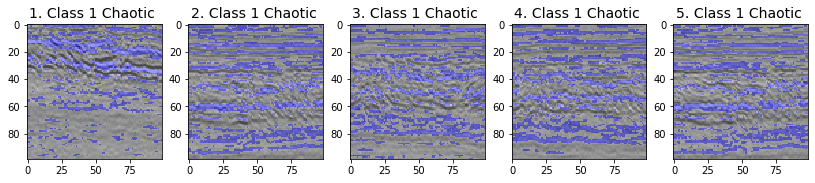

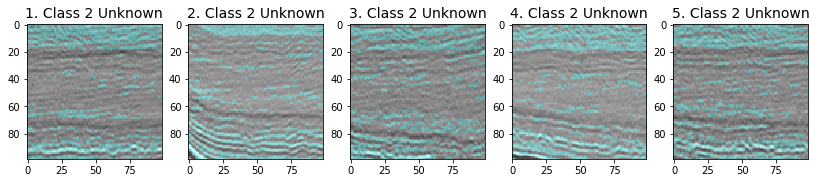

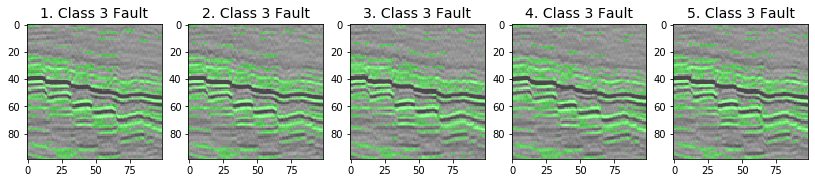

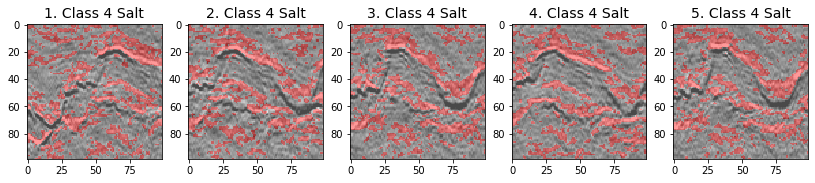

In [37]:
temp1 = np.zeros((numImages, width, length, 3)) # 3 channels
color_img = np.uint8(temp1)
color_img[class1[0], class1[1], class1[2], :] = [0,0,255] # blue chaotic
color_img[class2[0], class2[1], class2[2], :] = [100,255,255] # light blue unkown
color_img[class3[0], class3[1], class3[2], :] = [0,255,0] # green fault 
color_img[class4[0], class4[1], class4[2], :] = [255,0,0] # red salt
color_img[background[0], background[1],background[2], :] = [183,183,183] # grey

# Plot
fig, axarr = plt.subplots(1, 5, figsize=(14, 14))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n], cmap='gray')
    ax.imshow(color_img[n], alpha=.4)
    ax.set_title("%i. " % (n+1) + "Class 1 Chaotic " , fontsize=14)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(14, 14))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n+500], cmap='gray')
    ax.imshow(color_img[n+500], alpha=.4)
    ax.set_title("%i. " % (n+1) + "Class 2 Unknown", fontsize=14)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(14, 14))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n+1000], cmap='gray')
    ax.imshow(color_img[n+1000], alpha=.4)
    ax.set_title("%i. " % (n+1) + "Class 3 Fault", fontsize=14)
plt.show()
fig, axarr = plt.subplots(1, 5, figsize=(14, 14))
for ax, n in zip(axarr.flatten(), np.arange(5)):
    ax.imshow(array_data[n+1500], cmap='gray')
    ax.imshow(color_img[n+1500], alpha=.4)
    ax.set_title("%i. " % (n+1) + "Class 4 Salt", fontsize=14)
plt.show()

# f, axs = plt.subplots(1,2,figsize=(10,10))
# axs[0].imshow(array_data[1501], cmap='afmhot')
# axs[0].imshow(color_img, alpha=.6)
# axs[0].set_title("Pixel-level Labeled Image")
# axs[1].imshow(array_data[1501], cmap='afmhot')
# axs[1].set_title("Original bounding box image")


###  Validation: validate accuracy of chaotic and fault an salt class

In [27]:
# numbers = re.compile(r'(\d+)')
# def numSortFiles(words):
#     portion = numbers.split(words)
#     portion[1::2] = map(int, portion[1::2])
#     return portion
# # key = numSortFiles
# salt_path ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/ground truth/salt mask/mask_sa'
# fa = glob.glob(fault_path  + "/*.png")
# # fa = os.listdir(salt_path)
# fa.sort(key=lambda sortNum: int(re.sub('\D', '', sortNum)))

Showing the 10 image with predicted mask and ground truth.
There are 30  mask for each class.
2


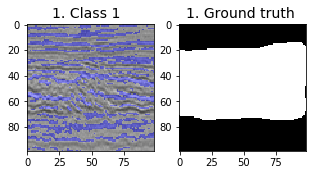

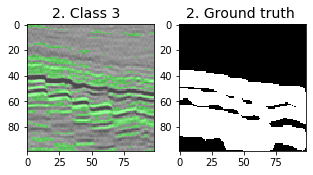

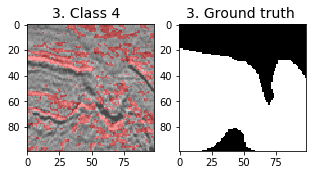

In [38]:
# Import mask
chaotic_path ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/ground truth/chaotic mask/mask_ch'
fault_path ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/ground truth/fault mask/mask_fa'
salt_path ='C:/Users/Tsaip/OneDrive - Imperial College London/Ovation Data Internship 2020/Data/ContenSimilarityTest/ground truth/salt mask/mask_sa'

path = [chaotic_path,fault_path,salt_path]

# To be written into a function
# def loadMask(Mask_path, length, width):
files = []
for p in path:
    # Assume each class has the same number of mask
    fileList = glob.glob(p + "/*.png")
    fileList.sort(key = lambda sortNum: int(re.sub('\D', '', sortNum)))
    files.append(fileList)
    
mask_truth = np.zeros((len(files),len(files[0]), width, length))
n = 0

for f in files:
    for path_m, k in zip(f, range(len(files[0]))):
        im = imageio.imread(path_m)
        mask_truth[n][k] = rgb2gray(im) # Turn RGB to gray scale
    n+= 1

mask_truth[mask_truth>0] = 1

classL = [0, 2, 3]
maskNum = len(files[0])
imgIdx = 10 
if imgIdx > maskNum :
    imgIdx = maskNum-1
print('Showing the %i'%imgIdx,'image with predicted mask and ground truth.')
for n, c in zip(range(maskNum), classL):
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    ax[0].imshow(array_data[c*numImagesPerClass+imgIdx], cmap='gray')
    ax[0].imshow(color_img[c*numImagesPerClass+imgIdx], alpha=.4)
    ax[0].set_title("%i. " % (n+1) + "Class %i  " %(c+1), fontsize=14)
    ax[1].imshow(mask_truth[n][imgIdx], cmap='gray')
    ax[1].set_title("%i. " % (n+1) + "Ground truth ", fontsize=14)
    fig.savefig('PredvsTruth%i.jpg'%(c+1))
    

print('There are', maskNum , ' mask for each class.')
print(n)

In [29]:
# kkk=classified_all[1000:1000+maskNum]
# classL = [0, 2, 3] # class label for validation
# mask_truth[mask_truth==0] = 5
# for n in range(len(classL)):
#     temp = mask_truth[n]
#     temp[temp == 1] = classL[n]
#     mask_truth[n] = temp


In [30]:
np.where(mask_truth[0]==0)[0].shape
maskNum

30

In [39]:
# We don't validate unkown class's accuracy. Just class 1, 3, 4
# Class1 label = 0, Class2 label = 1,Class3 label = 2, Class4 label = 3
   
pred1 = classified_all[:maskNum] # chaotic
pred3 = classified_all[1000:1000+maskNum] #fault
pred4 = classified_all[1500:1500+maskNum] #salt


In [40]:
# Convert background label to zeros

pred1[pred1==0] = 1
pred3[pred3==2] = 1
pred4[pred4==3] = 1

pred1[pred1==5] = 0
pred3[pred3==5] = 0
pred4[pred4==5] = 0

mask_pred = [pred1, pred3, pred4]
y_truth = np.zeros((len(mask_truth), maskNum, width*length))
y_pred = np.zeros((len(mask_truth), maskNum, width*length))
for n in range(len(mask_truth)):
    for ii in range(maskNum):
        y_truth[n,ii,:] = mask_truth[n][ii].flatten()
        y_pred[n,ii,:] = mask_pred[n][ii].flatten()


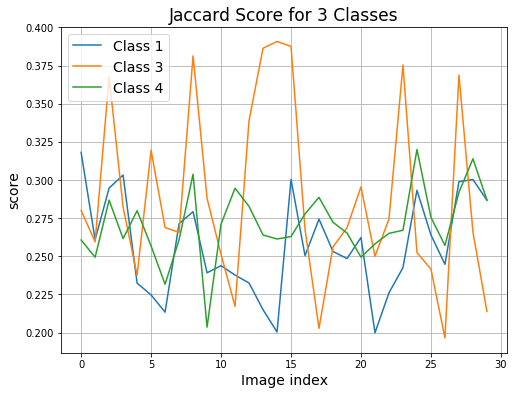

In [41]:
# Jaccard Score
#  intersection of binary images y_predict and y_true divided by the union of BW1 and BW2
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_title('Jaccard Score for 3 Classes',fontsize = 17)
jacc_score = np.zeros((len(mask_truth), maskNum))
for n in range(len(mask_truth)):
    for kk in range(maskNum):
        jacc_score[n][kk] = jaccard_score(y_truth[n][kk], y_pred[n][kk], average = 'binary')
    ax.plot(np.arange(maskNum), jacc_score[n], label="Class %i"%(classL[n]+1))
    ax.set_xlabel('Image index', fontsize = 14)
    ax.set_ylabel('score',fontsize = 14)
    ax.legend(loc='best',fontsize = 14)
    ax.grid()

In [42]:
# Accuracy score
# Number of correctly labelled/Number of total pixel
print('accuracy score')
for n in range(len(mask_truth)):
    cf = accuracy_score(y_truth[n].flatten(), y_pred[n].flatten())
    print("Class",n+1,':',cf)

accuracy score
Class 1 : 0.4754616875828997
Class 2 : 0.6082508587559092
Class 3 : 0.4407033295922185


<Figure size 576x720 with 0 Axes>

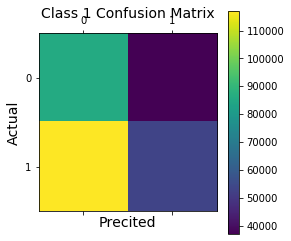

<Figure size 576x720 with 0 Axes>

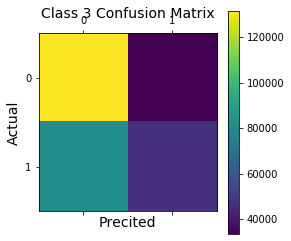

<Figure size 576x720 with 0 Axes>

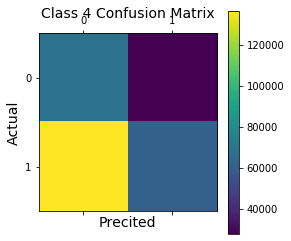

In [43]:
# Confusion matrix by class
# for kk in range(maskNum):
#     tn, fp, fn, tp  = confusion_matrix(y_truth[1][kk], y_pred[1][kk]).ravel()
#      print(tn, fp, fn, tp)

for n in range(len(mask_truth)):
    fig = plt.figure(figsize=(8,10))
    cf = confusion_matrix(y_truth[n].flatten(), y_pred[n].flatten())
    plt.matshow(cf)
    plt.title('Class %i Confusion Matrix'%(classL[n]+1), fontsize = 14)
    plt.colorbar()
    plt.xlabel('Precited',fontsize = 14)
    plt.ylabel('Actual',fontsize = 14)
    plt.show()
    fig.savefig('Class%iConfusionMatrix.png'%(classL[n]+1))

### ===================== The following is for single image mask =======================

In [ ]:
# Get the maximun value of each row 
vals= np.max(Y[1501,:,:],axis = 1)
# Using vals to show which area has more confidence
# Sum of each row
conf = np.divide(vals, np.sum(Y[1501,:,:],axis = 1)+1e-6)
conf = np.reshape(conf, (99, 99))
# Get the column index of maximum value. The index indicate which class the pixel falls in.
classImg = np.argmax(Y[1501,:,:],axis = 1)
classImg = np.reshape(classImg, (99, 99))
classifiedImage = median_filter(classImg,size = (3,3), mode = 'reflect')
# Turn all the low confidence pixels to other class, class 5
threshold = np.mean(conf)
print(threshold)
pixel_to5 = np.where(conf<threshold)
classifiedImage[pixel_to5[0], pixel_to5[1]] = 5
# Check how many pixels are label 2
print(classifiedImage.shape)
label_ = np.where(classifiedImage==5)
print(len(label_[0]))
em = np.where(conf<threshold)
em[0].shape


### Output Coordination and create a colored mask
- visualizes slices and projections through a 3D dataset

In [ ]:
# output coordination of feature pixel
class1 = np.where(classifiedImage==0)
class2 = np.where(classifiedImage==1)
class3 = np.where(classifiedImage==2)
class4 = np.where(classifiedImage==3)
background = np.where(classifiedImage==5)


In [ ]:
temp1 = np.zeros((99, 99, 3))
color_img = np.uint8(temp1)
color_img[class1[0], class1[1], :] = [0,0,255] # blue chaotic
color_img[class2[0], class2[1], :] = [100,255,255] # light blue unkown
color_img[class3[0], class3[1], :] = [0,255,0] # green fault 
color_img[class4[0], class4[1], :] = [255,0,0] # red salt
color_img[background[0], background[1], :] = [183,183,183] # grey

# plt.imshow(array_data[1501], cmap='afmhot')
# plt.imshow(color_img, alpha=.8)
# plt.title('Auto-scaled Aspect')

f, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(array_data[1501], cmap='afmhot')
axs[0].imshow(color_img, alpha=.6)
axs[0].set_title("Pixel-level Labeled Image")
axs[1].imshow(array_data[1501], cmap='afmhot')
axs[1].set_title("Original bounding box image")

